# 一.导入包和数据预处理

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.rcParams['font.size'] = 22
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn import metrics

#import featuretools as ft

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

import gc

/Users/kyzhang/anaconda/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#检测文件目录
import os
print(os.listdir("../input/"))

['data.csv']


In [3]:
#读取数据
data = pd.read_csv("../input/data.csv",encoding="gb18030")

In [4]:
data.head()

,Unnamed: 0,custid,trade_no,bank_card_no,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,...,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
0,5,2791858,20180507115231274000000023057383,卡号1,0.01,0.99,0,0.90,0.55,0.313,...,2900.0,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0
1,10,534047,20180507121002192000000023073000,卡号1,0.02,0.94,2000,1.28,1.00,0.458,...,3500.0,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0
2,12,2849787,20180507125159718000000023114911,卡号1,0.04,0.96,0,1.00,1.00,0.114,...,1600.0,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0
3,13,1809708,20180507121358683000000388283484,卡号1,0.00,0.96,2000,0.13,0.57,0.777,...,3200.0,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0
4,14,2499829,20180507115448545000000388205844,卡号1,0.01,0.99,0,0.46,1.00,0.175,...,2300.0,1630.0,8300.0,79.0,2.0,2.0,8400.0,8250.0,22.0,120.0


In [5]:
#数据形状
print(data.shape)

(4754, 90)


In [6]:
#每列数据个数
data.apply(pd.Series.nunique, axis=0)

Unnamed: 0                               4754
custid                                   4754
trade_no                                 4754
bank_card_no                                1
low_volume_percent                         40
middle_volume_percent                      90
take_amount_in_later_12_month_highest     166
trans_amount_increase_rate_lately         782
trans_activity_month                       84
trans_activity_day                        512
transd_mcc                                 41
trans_days_interval_filter                147
trans_days_interval                       114
regional_mobility                           5
student_feature                             2
repayment_capability                     2390
is_high_user                                2
number_of_trans_from_2011                  70
first_transaction_time                   1693
historical_trans_amount                  4524
historical_trans_day                      476
rank_trad_1_month                 

#  二.探索性数据分析（EDA）

###  总览

Number of not overdue:  3561
Number of overdue :  1193


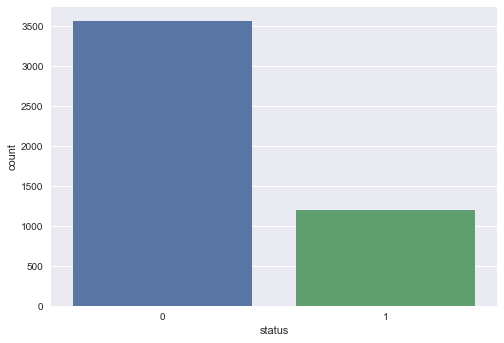

In [7]:
sns.countplot(data.status, label="Count")
N, Y = data.status.value_counts()
print('Number of not overdue: ',N)
print('Number of overdue : ',Y)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 90 columns):
Unnamed: 0                                    4754 non-null int64
custid                                        4754 non-null int64
trade_no                                      4754 non-null object
bank_card_no                                  4754 non-null object
low_volume_percent                            4752 non-null float64
middle_volume_percent                         4752 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4751 non-null float64
trans_activity_month                          4752 non-null float64
trans_activity_day                            4752 non-null float64
transd_mcc                                    4752 non-null float64
trans_days_interval_filter                    4746 non-null float64
trans_days_interval                           4752 non-null float64
regional_mobility

In [9]:
#列类型统计
data.dtypes.value_counts()

float64    70
int64      13
object      7
dtype: int64

In [10]:
 #列出object属性
list_obj = [f for f in data.columns if data[f].dtype == 'object']

In [11]:
print(list_obj)

['trade_no', 'bank_card_no', 'reg_preference_for_trad', 'source', 'id_name', 'latest_query_time', 'loans_latest_time']


### 去除无关数据，分组数组

In [12]:
# 去掉所有都不同和所有都相同的列
drop_list = ['Unnamed: 0','trade_no','bank_card_no','source']
data.drop(drop_list, axis=1, inplace=True)
# 去掉无关的列
data.drop("id_name", axis=1, inplace=True)
# 为避免产生噪声，去掉缺失值比例过大的student_feature特征
data.drop("student_feature", axis=1, inplace=True)

In [13]:
#把数据分为 object型 和 数值型
data_obj_ls=['reg_preference_for_trad', 'latest_query_time', 'loans_latest_time']
data_obj = data[data_obj_ls]
data_num = data.drop(data_obj_ls, axis=1)

In [14]:
data_obj.describe()

,reg_preference_for_trad,latest_query_time,loans_latest_time
count,4752,4450,4457
unique,5,207,232
top,一线城市,2018-04-14,2018-05-03
freq,3403,423,134


In [15]:
#每个object列中的唯一类数
data.describe(include=[np.object])

,reg_preference_for_trad,latest_query_time,loans_latest_time
count,4752,4450,4457
unique,5,207,232
top,一线城市,2018-04-14,2018-05-03
freq,3403,423,134


In [16]:
print(data.reg_preference_for_trad.value_counts())

一线城市    3403
三线城市    1064
境外       150
二线城市     131
其他城市       4
Name: reg_preference_for_trad, dtype: int64


In [17]:
data_add_list = ["reg_preference_for_trad","latest_query_time","latest_query_time"]
data_add = data[data_add_list]
# data.drop([data_add_list], axis=1, inplace=True)

## 2.2 检测缺失值

In [18]:
# 按列计算缺失值
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        # 按缺失降序的百分比对表进行排序
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        # 输出主要信息
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        # 返回缺失值的列表
        return mis_val_table_ren_columns

In [19]:
#缺失值统计
missing_values = missing_values_table(data)
missing_values.head(10)

Your selected dataframe has 84 columns.
There are 72 columns that have missing values.


,Missing Values,% of Total Values
cross_consume_count_last_1_month,426,9.0
query_sum_count,304,6.4
latest_three_month_apply,304,6.4
latest_one_month_apply,304,6.4
latest_query_time,304,6.4
query_cash_count,304,6.4
query_finance_count,304,6.4
query_org_count,304,6.4
apply_credibility,304,6.4
apply_score,304,6.4


### 缺失值处理

In [20]:
#数值型 缺失值处理
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='mean')
num = imputer.fit_transform(data_num)
data_num = pd.DataFrame(num, columns=data_num.columns)

In [21]:
#标签型 缺失值处理
data_obj.ffill(inplace=True)

### 数值化
+ 标签编码（两个特征）
+ 独热编码（两个以上特征）

In [22]:
# 标签化 处理”reg_preference_for_trad“
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
reg_preference_onehot = encoder.fit_transform(data_obj['reg_preference_for_trad'])
data_obj.drop(['reg_preference_for_trad'], axis=1, inplace=True)


reg_preference_data = pd.DataFrame(reg_preference_onehot, columns=encoder.classes_)
data_obj = pd.concat([data_obj, reg_preference_data], axis=1)

In [23]:
# 处理 latest_query_time 和 loans_latest_time 特征

data_obj['latest_query_time'] = pd.to_datetime(data_obj['latest_query_time'])
data_obj['latest_query_time_month'] = data_obj['latest_query_time'].dt.month
data_obj['latest_query_time_weekday'] = data_obj['latest_query_time'].dt.weekday

data_obj['loans_latest_time'] = pd.to_datetime(data_obj['loans_latest_time'])
data_obj['loans_latest_time_month'] = data_obj['loans_latest_time'].dt.month
data_obj['loans_latest_time_weekday'] = data_obj['loans_latest_time'].dt.weekday

data_obj = data_obj.drop(['latest_query_time', 'loans_latest_time'], axis=1)

In [24]:
print(data_obj.head(5))

   一线城市  三线城市  二线城市  其他城市  境外  latest_query_time_month  \
0     1     0     0     0   0                        4   
1     1     0     0     0   0                        5   
2     1     0     0     0   0                        5   
3     0     1     0     0   0                        5   
4     1     0     0     0   0                        4   

   latest_query_time_weekday  loans_latest_time_month  \
0                          2                        4   
1                          3                        5   
2                          5                        5   
3                          5                        5   
4                          6                        1   

   loans_latest_time_weekday  
0                          3  
1                          5  
2                          1  
3                          3  
4                          6  


In [25]:
print(data_num.head(5))

      custid  low_volume_percent  middle_volume_percent  \
0  2791858.0                0.01                   0.99   
1   534047.0                0.02                   0.94   
2  2849787.0                0.04                   0.96   
3  1809708.0                0.00                   0.96   
4  2499829.0                0.01                   0.99   

   take_amount_in_later_12_month_highest  trans_amount_increase_rate_lately  \
0                                    0.0                               0.90   
1                                 2000.0                               1.28   
2                                    0.0                               1.00   
3                                 2000.0                               0.13   
4                                    0.0                               0.46   

   trans_activity_month  trans_activity_day  transd_mcc  \
0                  0.55               0.313        17.0   
1                  1.00               0.458        1

## 2.3 异常值

In [26]:
data.describe()

,custid,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,...,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
count,4.754000e+03,4752.000000,4752.000000,4754.000000,4751.000000,4752.000000,4752.000000,4752.000000,4746.000000,4752.000000,...,4457.000000,4457.000000,4457.000000,4457.000000,4457.000000,4457.000000,4457.000000,4457.000000,4450.000000,4457.000000
mean,1.690993e+06,0.021806,0.901294,1940.197728,14.160674,0.804411,0.365425,17.502946,29.029920,21.751263,...,3390.038142,1820.357864,9187.009199,76.042630,4.732331,5.227507,16153.690823,8007.696881,24.112809,55.181512
std,1.034235e+06,0.041527,0.144856,3923.971494,694.180473,0.196920,0.170196,4.475616,22.722432,16.474916,...,1474.206546,583.418291,7371.257043,14.536819,2.974596,3.409292,14301.037628,5679.418585,37.725724,53.486408
min,1.140000e+02,0.000000,0.000000,0.000000,0.000000,0.120000,0.033000,2.000000,0.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,-2.000000
25%,7.593358e+05,0.010000,0.880000,0.000000,0.615000,0.670000,0.233000,15.000000,16.000000,12.000000,...,2300.000000,1535.000000,4800.000000,77.000000,2.000000,3.000000,7800.000000,4737.000000,5.000000,10.000000
50%,1.634942e+06,0.010000,0.960000,500.000000,0.970000,0.860000,0.350000,17.000000,23.000000,17.000000,...,3100.000000,1810.000000,7700.000000,79.000000,4.000000,5.000000,13800.000000,7050.000000,14.000000,36.000000
75%,2.597905e+06,0.020000,0.990000,2000.000000,1.600000,1.000000,0.480000,20.000000,32.000000,27.000000,...,4300.000000,2100.000000,11700.000000,80.000000,7.000000,7.000000,20400.000000,10000.000000,24.000000,91.000000
max,4.004694e+06,1.000000,1.000000,68000.000000,47596.740000,1.000000,0.941000,42.000000,285.000000,234.000000,...,10000.000000,6900.000000,87100.000000,87.000000,18.000000,20.000000,266400.000000,82800.000000,360.000000,323.000000


In [27]:
# 定义去除异常值函数
def drop_Outlier(ftr,df):
    upper_q = df[ftr].quantile(0.75)
    lower_q = df[ftr].quantile(0.25)
    q_int = upper_q - lower_q
    k = 1.5
    df[df[ftr]>lower_q - k * q_int][df[ftr] < upper_q + k*q_int]

In [28]:
# 去除data_num中的异常值
for i in data_num.columns:
    drop_Outlier(i,data_num)

In [29]:
# 去除data_obj中的异常值
for i in data_obj.columns:
    drop_Outlier(i,data_obj)

## 2.4 合并数据

In [30]:
data_new = pd.concat([data_num, data_obj], axis=1)
data_new.head()

,custid,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,...,loans_latest_day,一线城市,三线城市,二线城市,其他城市,境外,latest_query_time_month,latest_query_time_weekday,loans_latest_time_month,loans_latest_time_weekday
0,2791858.0,0.01,0.99,0.0,0.90,0.55,0.313,17.0,27.0,26.0,...,18.0,1,0,0,0,0,4,2,4,3
1,534047.0,0.02,0.94,2000.0,1.28,1.00,0.458,19.0,30.0,14.0,...,2.0,1,0,0,0,0,5,3,5,5
2,2849787.0,0.04,0.96,0.0,1.00,1.00,0.114,13.0,68.0,22.0,...,6.0,1,0,0,0,0,5,5,5,1
3,1809708.0,0.00,0.96,2000.0,0.13,0.57,0.777,22.0,14.0,6.0,...,4.0,0,1,0,0,0,5,5,5,3
4,2499829.0,0.01,0.99,0.0,0.46,1.00,0.175,13.0,66.0,42.0,...,120.0,1,0,0,0,0,4,6,1,6


In [31]:
#切分数据，测试集30%，训练集70%，随机种子设置为2018
from sklearn.model_selection import train_test_split
random_state = 2018
train, test = train_test_split(data_new, test_size=0.3, random_state=random_state)
print("Training data shape: ", train.shape)
print("Tesing data shape: ", test.shape)

Training data shape:  (3327, 90)
Tesing data shape:  (1427, 90)


# 三. 特征工程

In [32]:
#划分训练数据和训练结果
y_train = train.status
X_train = train.drop("status", axis=1)
#划分测试数据和测试结果
y_test = test.status
X_test = test.drop("status", axis=1)

In [33]:
X_train.head()

,custid,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,...,loans_latest_day,一线城市,三线城市,二线城市,其他城市,境外,latest_query_time_month,latest_query_time_weekday,loans_latest_time_month,loans_latest_time_weekday
110,3302657.0,0.01,0.99,4000.0,0.96,1.00,0.405,16.0,29.0,28.0,...,9.0,1,0,0,0,0,5,4,4,2
3394,2733732.0,0.03,0.97,500.0,0.87,1.00,0.205,18.0,27.0,27.0,...,27.0,1,0,0,0,0,4,5,4,1
3052,2851871.0,0.02,0.86,0.0,1.98,0.70,0.205,18.0,53.0,33.0,...,137.0,1,0,0,0,0,5,4,12,3
490,63272.0,0.02,0.81,1000.0,1.49,0.73,0.555,23.0,15.0,8.0,...,51.0,0,1,0,0,0,4,1,3,5
1,534047.0,0.02,0.94,2000.0,1.28,1.00,0.458,19.0,30.0,14.0,...,2.0,1,0,0,0,0,5,3,5,5


In [34]:
from sklearn.metrics import accuracy_score, roc_auc_score,recall_score,f1_score

def model_metrics(clf, X_train, X_test, y_train, y_test):
    # 预测
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    y_train_proba = clf.predict_proba(X_train)[:,1]
    y_test_proba = clf.predict_proba(X_test)[:,1]
    
    # 准确率
    print('[准确率]', end = ' ')
    print('训练集：', '%.4f'%accuracy_score(y_train, y_train_pred), end = ' ')
    print('测试集：', '%.4f'%accuracy_score(y_test, y_test_pred))
    
    # auc取值：用roc_auc_score或auc
    print('[auc值]', end = ' ')
    print('训练集：', '%.4f'%roc_auc_score(y_train, y_train_proba), end = ' ')
    print('测试集：', '%.4f'%roc_auc_score(y_test, y_test_proba))
    
#     # recall
#     print('[recall值]', end = ' ')
#     print('训练集：', '%.4f '%recall_score(y_train, y_train_proba), end = ' ')
#     print('测试集：', '%.4f '%recall_score(y_test, y_test_proba))
    
#     # F1
#     print('[F1值]', end = ' ')
#     print('训练集：', '%.4f '%f1_score(y_train, y_train_proba), end = ' ')
#     print('测试集：', '%.4f '%f1_score(y_test, y_test_proba))

### 3.1 随机森林特征选择

In [35]:
from sklearn import metrics
#随机森林
from sklearn.ensemble import  RandomForestClassifier


rf0 = RandomForestClassifier(n_estimators=1000, oob_score=True, random_state=2018)
rf0.fit(X_train, y_train)
print('袋外分数：', rf0.oob_score_)
model_metrics(rf0, X_train, X_test, y_train, y_test)


袋外分数： 0.792605951307
[准确率] 训练集： 1.0000 测试集： 0.7856
[auc值] 训练集： 1.0000 测试集： 0.7614


In [36]:
#特征贡献度排名
featimp = pd.Series(rf0.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(featimp.head(10))

trans_fail_top_count_enum_last_1_month    0.051107
history_fail_fee                          0.048411
loans_score                               0.036639
apply_score                               0.028545
loans_overdue_count                       0.024374
latest_one_month_fail                     0.021188
trans_amount_3_month                      0.016246
trans_day_last_12_month                   0.015679
max_cumulative_consume_later_1_month      0.015646
repayment_capability                      0.015388
dtype: float64


In [37]:
threshold = 0.01
data_index = list(X_train.columns[ rf0.feature_importances_ < threshold])
X_train.drop(data_index,axis=1,inplace=True)
X_train.shape

(3327, 46)

In [38]:
X_train.columns

Index(['custid', 'trans_amount_increase_rate_lately', 'trans_activity_month',
       'trans_activity_day', 'transd_mcc', 'trans_days_interval_filter',
       'trans_days_interval', 'repayment_capability',
       'number_of_trans_from_2011', 'first_transaction_time',
       'historical_trans_amount', 'historical_trans_day', 'rank_trad_1_month',
       'trans_amount_3_month', 'abs', 'avg_price_last_12_month',
       'trans_top_time_last_1_month', 'trans_top_time_last_6_month',
       'consume_top_time_last_1_month', 'consume_top_time_last_6_month',
       'trans_fail_top_count_enum_last_1_month',
       'trans_fail_top_count_enum_last_6_month',
       'trans_fail_top_count_enum_last_12_month',
       'max_cumulative_consume_later_1_month',
       'pawns_auctions_trusts_consume_last_6_month', 'first_transaction_day',
       'trans_day_last_12_month', 'apply_score', 'apply_credibility',
       'loans_score', 'loans_count', 'loans_settle_count',
       'loans_overdue_count', 'history_suc_fe

#### 用预测出的5个特征继续做

In [39]:
prediction_var = X_train.columns

In [40]:
#划分训练数据和训练结果
X_train = train[prediction_var]
y_train = train.status
#划分测试数据和测试结果
X_test = test[prediction_var]
y_test = test.status

In [41]:
#随机森林选择贡献度大于0.01的特征测试
rf0 = RandomForestClassifier(n_estimators=1000, oob_score=True, random_state=2018)
rf0.fit(X_train, y_train)
print('袋外分数：', rf0.oob_score_)
model_metrics(rf0, X_train, X_test, y_train, y_test)

袋外分数： 0.796813946498
[准确率] 训练集： 1.0000 测试集： 0.7863
[auc值] 训练集： 1.0000 测试集： 0.7639


### 3.2 IV值进行特征选择

In [42]:
#划分训练数据和训练结果
y_train = train.status
X_train = train.drop("status", axis=1)
#划分测试数据和测试结果
y_test = test.status
X_test = test.drop("status", axis=1)

In [43]:
#封装计算iv的方法
import math
import numpy as np
from scipy import stats
from sklearn.utils.multiclass import type_of_target

def woe(X, y, event=1):  
    res_woe = []
    iv_dict = {}
    for feature in X.columns:
        x = X[feature].values
        # 1) 连续特征离散化
        if type_of_target(x) == 'continuous':
            x = discrete(x)
        # 2) 计算该特征的woe和iv
        # woe_dict, iv = woe_single_x(x, y, feature, event)
        woe_dict, iv = woe_single_x(x, y, feature, event)
        iv_dict[feature] = iv
        res_woe.append(woe_dict) 
        
    return iv_dict
        
def discrete(x):
    # 使用5等分离散化特征
    res = np.zeros(x.shape)
    for i in range(5):
        point1 = stats.scoreatpercentile(x, i * 20)
        point2 = stats.scoreatpercentile(x, (i + 1) * 20)
        x1 = x[np.where((x >= point1) & (x <= point2))]
        mask = np.in1d(x, x1)
        res[mask] = i + 1    # 将[i, i+1]块内的值标记成i+1
    return res

def woe_single_x(x, y, feature,event = 1):
    # event代表预测正例的标签
    event_total = sum(y == event)
    non_event_total = y.shape[-1] - event_total
    
    iv = 0
    woe_dict = {}
    for x1 in set(x):    # 遍历各个块
        y1 = y.reindex(np.where(x == x1)[0])
        event_count = sum(y1 == event)
        non_event_count = y1.shape[-1] - event_count
        rate_event = event_count / event_total    
        rate_non_event = non_event_count / non_event_total
        
        if rate_event == 0:
            rate_event = 0.0001
            # woei = -20
        elif rate_non_event == 0:
            rate_non_event = 0.0001
            # woei = 20
        woei = math.log(rate_event / rate_non_event)
        woe_dict[x1] = woei
        iv += (rate_event - rate_non_event) * woei
    return woe_dict, iv

In [44]:
import warnings
warnings.filterwarnings("ignore")

iv_dict = woe(X_train, y_train)
iv = sorted(iv_dict.items(), key = lambda x:x[1],reverse = True)
iv

[('custid', 2.6909066431469095),
 ('historical_trans_amount', 2.6609646134512865),
 ('trans_amount_3_month', 2.5546436077538357),
 ('repayment_capability', 2.327229251967252),
 ('pawns_auctions_trusts_consume_last_6_month', 2.220777389641486),
 ('abs', 1.966985825643712),
 ('max_cumulative_consume_later_1_month', 1.4598660465564153),
 ('pawns_auctions_trusts_consume_last_1_month', 0.8530625616084101),
 ('avg_price_last_12_month', 0.7281431950917352),
 ('take_amount_in_later_12_month_highest', 0.4407207265219969),
 ('latest_query_time_month', 0.25139126628755865),
 ('loans_latest_time_weekday', 0.24326338644309412),
 ('history_fail_fee', 0.23601952893571299),
 ('loans_latest_time_month', 0.23316679232272933),
 ('latest_query_day', 0.23165030755336188),
 ('history_suc_fee', 0.23132587006862826),
 ('trans_days_interval', 0.23127346695672282),
 ('trans_activity_day', 0.23089021521474926),
 ('latest_six_month_apply', 0.23004076549705482),
 ('apply_score', 0.22999736959648898),
 ('loans_avg_

# 4.模型构建

### 归一化处理

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score,roc_curve, auc

In [59]:
def model_metrics(clf, X_train, X_test, y_train, y_test):
    # 预测
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    y_train_proba = clf.predict_proba(X_train)[:,1]
    y_test_proba = clf.predict_proba(X_test)[:,1]
    
    # 准确率
    print('[准确率]', end = ' ')
    print('训练集：', '%.4f'%accuracy_score(y_train, y_train_pred), end = ' ')
    print('测试集：', '%.4f'%accuracy_score(y_test, y_test_pred))
    
    # 精准率
    print('[精准率]', end = ' ')
    print('训练集：', '%.4f'%precision_score(y_train, y_train_pred), end = ' ')
    print('测试集：', '%.4f'%precision_score(y_test, y_test_pred))

    # 召回率
    print('[召回率]', end = ' ')
    print('训练集：', '%.4f'%recall_score(y_train, y_train_pred), end = ' ')
    print('测试集：', '%.4f'%recall_score(y_test, y_test_pred))
    
    # f1-score
    print('[f1-score]', end = ' ')
    print('训练集：', '%.4f'%f1_score(y_train, y_train_pred), end = ' ')
    print('测试集：', '%.4f'%f1_score(y_test, y_test_pred))
    
    # auc取值：用roc_auc_score或auc
    print('[auc值]', end = ' ')
    print('训练集：', '%.4f'%roc_auc_score(y_train, y_train_proba), end = ' ')
    print('测试集：', '%.4f'%roc_auc_score(y_test, y_test_proba))
    
    # roc曲线
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_proba, pos_label = 1)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba, pos_label = 1)
    
    label = ["Train - AUC:{:.4f}".format(auc(fpr_train, tpr_train)), 
             "Test - AUC:{:.4f}".format(auc(fpr_test, tpr_test))]
    plt.plot(fpr_train,tpr_train)
    plt.plot(fpr_test,tpr_test)
    plt.plot([0, 1], [0, 1], 'd--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(label, loc = 4)
    plt.title("ROC curve")

In [60]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.fit_transform(X_test)

In [61]:
print(X_train_std)

[[ 1.55535815 -0.29119561  0.61075427 ...,  0.33431403 -0.19696883
  -0.52274403]
 [ 1.00806289  0.19159563  0.47126106 ...,  0.85044525 -0.19696883
  -1.03729119]
 [ 1.12171041 -0.04979999 -0.29595156 ...,  0.33431403  2.37163591
  -0.00819687]
 ..., 
 [ 0.62886137 -0.53259123 -3.57404185 ..., -1.21407962  0.12410677
  -0.52274403]
 [-0.13943084 -0.53259123 -0.15645835 ...,  0.85044525 -0.19696883
  -0.52274403]
 [-1.26282116 -0.29119561 -0.01696515 ..., -1.73021084 -0.19696883
   1.02089744]]


### LR

[准确率] 训练集： 0.8031 测试集： 0.7821
[精准率] 训练集： 0.7002 测试集： 0.6212
[召回率] 训练集： 0.3753 测试集： 0.3426
[f1-score] 训练集： 0.4887 测试集： 0.4417
[auc值] 训练集： 0.8199 测试集： 0.7561


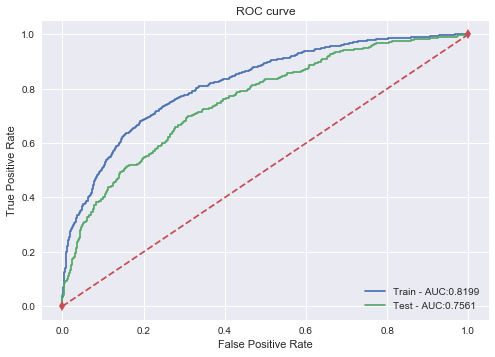

In [62]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_std, y_train)
model_metrics(lr, X_train_std, X_test_std, y_train, y_test)

### SVM

[准确率] 训练集： 0.8049 测试集： 0.7779
[精准率] 训练集： 0.7778 测试集： 0.6544
[召回率] 训练集： 0.3106 测试集： 0.2479
[f1-score] 训练集： 0.4439 测试集： 0.3596
[auc值] 训练集： 0.8173 测试集： 0.7678


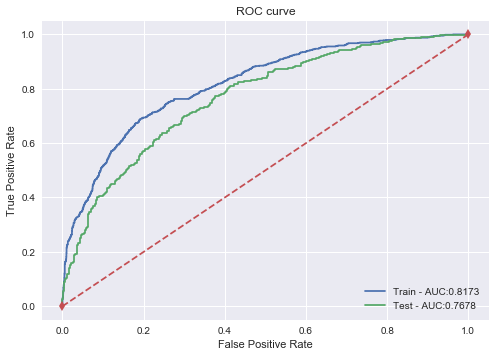

In [63]:
from sklearn.svm import  SVC
# 线性
linear_svc = SVC(kernel='linear', probability=True)
linear_svc.fit(X_train_std,y_train)
model_metrics(linear_svc, X_train_std, X_test_std, y_train, y_test)

[准确率] 训练集： 0.8049 测试集： 0.7779
[精准率] 训练集： 0.7778 测试集： 0.6544
[召回率] 训练集： 0.3106 测试集： 0.2479
[f1-score] 训练集： 0.4439 测试集： 0.3596
[auc值] 训练集： 0.8173 测试集： 0.7678


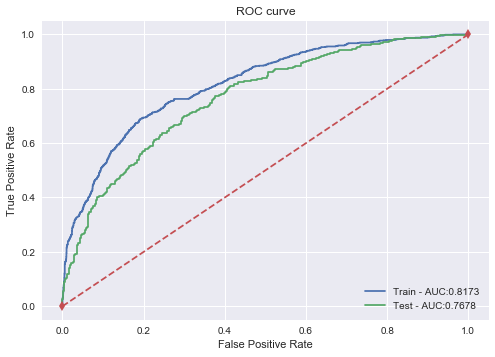

In [64]:
# 多项式
poly_svc = SVC(kernel='linear', probability=True)
poly_svc.fit(X_train_std,y_train)
model_metrics(poly_svc, X_train_std, X_test_std, y_train, y_test)

### 决策树

[准确率] 训练集： 1.0000 测试集： 0.6685
[精准率] 训练集： 1.0000 测试集： 0.3596
[召回率] 训练集： 1.0000 测试集： 0.4067
[f1-score] 训练集： 1.0000 测试集： 0.3817
[auc值] 训练集： 1.0000 测试集： 0.5816


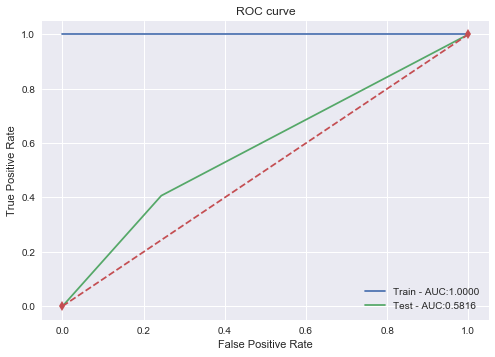

In [65]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train_std,y_train)
model_metrics(dt, X_train_std, X_test_std, y_train, y_test)

### XGBoost

[准确率] 训练集： 0.8942 测试集： 0.7786
[精准率] 训练集： 0.9350 测试集： 0.6114
[召回率] 训练集： 0.6211 测试集： 0.3287
[f1-score] 训练集： 0.7464 测试集： 0.4275
[auc值] 训练集： 0.9597 测试集： 0.7649


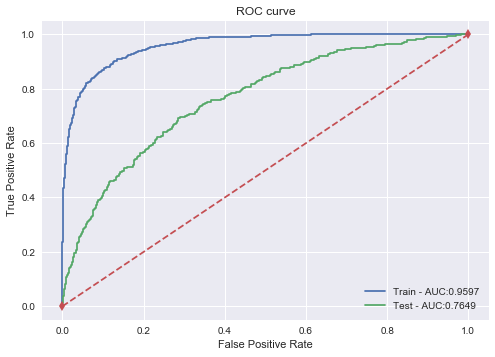

In [66]:
from xgboost.sklearn import XGBClassifier
xgb_params = {
    'learning_rate': 0.1,
    'n_estimators': 42,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'nthread': 4,
    'scale_pos_weight': 1,
    'seed': 112
}
xgb_model = XGBClassifier(**xgb_params)
xgb_model.fit(X_train_std, y_train)
model_metrics(xgb_model, X_train_std, X_test_std, y_train, y_test)

### LightGBM

[准确率] 训练集： 0.8861 测试集： 0.7765
[精准率] 训练集： 0.9317 测试集： 0.6176
[召回率] 训练集： 0.5887 测试集： 0.2925
[f1-score] 训练集： 0.7215 测试集： 0.3970
[auc值] 训练集： 0.9567 测试集： 0.7586


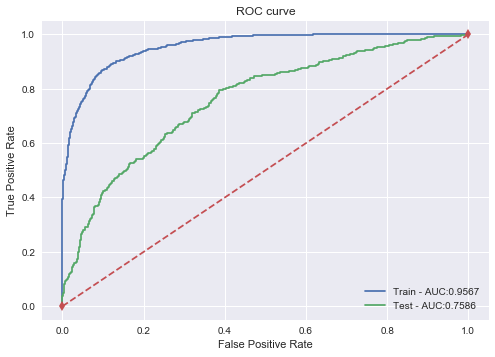

In [67]:
from lightgbm.sklearn import  LGBMClassifier
lgb_params  = {
    'learning_rate': 0.1,
    'n_estimators': 42,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary', # 这里和 xgb 不一样
    'nthread': 4,
    'scale_pos_weight': 1,
    'seed': 112
}
lgb_model = LGBMClassifier(**lgb_params) 
 
lgb_model.fit(X_train_std, y_train)
model_metrics(lgb_model, X_train_std, X_test_std, y_train, y_test)

# 5.模型评估

# 6.模型调优

# 7.模型融合